In [1]:
import os
import gc
import time
import random
import json
import shutil
import pickle
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
#import torchvision.transforms as transforms #duplicate
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image #using plt.imread instead

Data

Our dataset contains identically-named image/text pairs with extension .txt and .jpg respectively. Each line of each text file labels a block of text in the corresponding image; it contains 8 non-negative comma-separated integers (presumably position information), followed by the actual text. The blocks are ordered top-to-bottom, left-to-right, and row-major based on their position in the image (i.e. the order English is read in). Since all lines on a receipt are vertically aligned, the ordering used in the text files should be unambiguous and learnable by our CNN model.

In [2]:
data_dir = '../data'
data_filename = 'combined.zip'
data_path = os.path.join(data_dir, data_filename)
env_dir = '.'

In [ ]:
#unzip data
!unzip $data_path -d $env_dir

#remove metadata created from unzipping
hidden_dir = '__MACOSX'
if os.path.exists(hidden_dir):
    shutil.rmtree(hidden_dir)

In [3]:
data_dir = 'combined'
raw_img_path = os.path.join(data_dir, 'img')
raw_txt_path = os.path.join(data_dir, 'box')
raw_entity_path = os.path.join(data_dir, 'entities')

In [4]:
clean_txt_path = os.path.join(env_dir, 'clean_txt')
clean_img_path = os.path.join(env_dir, 'clean_img')

if not os.path.exists(clean_txt_path):
    os.makedirs(clean_txt_path)
if not os.path.exists(clean_img_path):
    os.makedirs(clean_img_path)

Since our RNN expects a space-separated string of receipt text, we remove the position information from its labels:

In [6]:
import re
import glob

#loop through raw txt files,
#remove position info,
#convert to space-separated string,
#save to clean_txt_path
for filename in os.listdir(raw_txt_path):
    file_path = os.path.join(raw_txt_path, filename)
    file = open(file_path, 'r', encoding='latin1') #default encoding utf8 is incompatible with '£'
    content = ''
    for line in file:
        assert(type(line) == str)
        line = line.strip() #remove leading/trailing whitespace/newlines
        line = re.sub(r"^\d+,\d+,\d+,\d+,\d+,\d+,\d+,\d+,", "", line) # Remove the comma-separated numbers
        line = re.sub(r" +", " ", line) # Replace multiple consecutive spaces with a single space
        if len(line):
            assert(line[0] != ' ' and line[-1] != ' ')
        content += line + ' '
    content = content.strip() #remove last space
    clean_path = os.path.join(clean_txt_path, filename)
    file = open(clean_path, 'w', encoding='latin1')
    file.write(content)

Pre-Process Image

  1. Scale + pad to match median dimension
  2. Grayscale Image to one channel
  3. Normalize the image using mean = 0.5 and std = 0.5





In [5]:
tensor_transform = transforms.Compose([transforms.ToTensor()])

def load_images(directory):
    image_list = []
    for filename in os.listdir(directory):
        assert filename.endswith(('.png', '.jpg', '.jpeg'))
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        img_tensor = tensor_transform(img)
        image_list.append(img_tensor)
    return image_list

In [21]:
if 'imgs' in globals():
    del imgs
    gc.collect()
imgs = load_images(raw_img_path) # ~150s

In [12]:
imgs[0].shape

torch.Size([3, 1528, 1080])

In [7]:
for img in imgs:
    if img.shape[0] != 3: #already grayscale
        print(img.shape)

torch.Size([1, 7016, 4961])
torch.Size([1, 7016, 4961])
torch.Size([1, 7016, 4961])
torch.Size([1, 7016, 4961])
torch.Size([1, 7016, 4961])
torch.Size([1, 7016, 4961])
torch.Size([1, 6701, 4854])
torch.Size([1, 7016, 4961])
torch.Size([1, 7016, 4961])
torch.Size([1, 7016, 4961])


In [8]:
#assume values is sorted
def calculate_median(values):
    length = len(values)
    if length % 2 == 0:  # even number of elements
        return (values[length // 2 - 1] + values[length // 2]) / 2
    else:  # odd number of elements
        return values[length // 2]

In [9]:
# find median image width, height
widths = []
heights = []

for img in imgs:
    widths.append(img.shape[2])
    heights.append(img.shape[1])

widths.sort()
heights.sort()
median_width = calculate_median(widths)
median_height = calculate_median(heights)
print(f"Median Width: {median_width}")
print(f"Median Height: {median_height}")

Median Width: 825
Median Height: 1697


In [23]:
#scale with padding; ~60s
for i, img in enumerate(imgs):
    # find scale factor
    w, h = img.shape[2], img.shape[1]
    scale_factor = min(median_width / w, median_height / h)
    new_size = (int(h * scale_factor), int(w * scale_factor))
    
    # Resize while maintaining aspect ratio
    resized_img = F.interpolate(img.unsqueeze(0), size=new_size, mode='bicubic')
    resized_img = resized_img.squeeze(0)
    
    # Pad the image to reach the target size
    pad_w = median_width - resized_img.shape[2]
    pad_h = median_height - resized_img.shape[1]
    padding = [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
    padded_img = F.pad(resized_img.unsqueeze(0), padding, value=1).squeeze(0)
    
    assert(padded_img.shape[2] == median_width)
    assert(padded_img.shape[1] == median_height)
    imgs[i] = padded_img

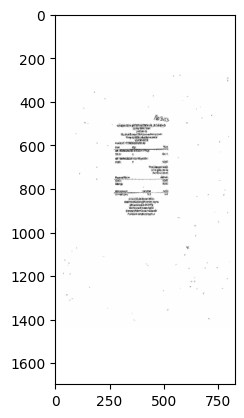

In [24]:
#plot an image to verify it looks normal
pil_transform = transforms.Compose([transforms.ToPILImage()])
plt.imshow(pil_transform(imgs[0]))

In [12]:
rgb_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((median_width, median_height)), transforms.Grayscale(1), transforms.Normalize((0.5),(0.5))])
l_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((median_width, median_height)), transforms.Normalize((0.5),(0.5))])

#transform and save imgs individually bc tensor containing all imgs doesn't fit in RAM
#batching images for transform may speed this up
for img_name in os.listdir(img_path):
    img_filepath = os.path.join(img_path, img_name)
    img = Image.open(img_filepath)
    if img.mode == "RGB":
        img = rgb_transform(img)
    else:
        img = l_transform(img)
    norm_img_name, __ = os.path.splitext(img_name)
    torch.save(img, os.path.join(norm_img_path, norm_img_name+'.pt'))

shutil.rmtree(img_path)

In [14]:
#function to get list of entity strings
def get_entity_strings(txt_path):
    file = open(txt_path, 'r', encoding='latin1')
    json_data = file.read()
    try:
        parsed_data = json.loads(json_data)
    except json.JSONDecodeError:
        print("Error: Invalid JSON format in the file.")
        parsed_data = {}
    result = [
        parsed_data.get("company", ""),
        parsed_data.get("date", ""),
        parsed_data.get("address", ""),
        parsed_data.get("total", "")
    ]
    return result

def get_data_loader(data_set, batch_size):
    data_loader = [data_set[i:i+batch_size] for i in range(0, len(data_set), batch_size)]
    return data_loader;

def get_data_entry(filename): #(img tensor, actual text string, list of entity strings)
    norm_img_filepath = os.path.join(norm_img_path, filename+'.pt')
    img = torch.load(norm_img_filepath)

    text_filepath = os.path.join(clean_txt_path, filename+'.txt')
    text_file = open(text_filepath, 'r', encoding='latin1')
    text = text_file.read()

    entities_path = os.path.join(entity_path, filename+'.txt')
    entities = get_entity_strings(entities_path)

    #remove to save disk space
    os.remove(norm_img_filepath)
    os.remove(text_filepath)
    os.remove(entities_path)
    return (img, text, entities)

Split data using 70-15-15 for train, val, test:

In [15]:
train_data_ratio = 0.7
val_data_ratio = 0.15
test_data_ratio = 1 - train_data_ratio - val_data_ratio

train_path = os.path.join(env_path, 'train')
val_path = os.path.join(env_path, 'val')
test_path = os.path.join(env_path, 'test')

if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(val_path):
    os.makedirs(val_path)
if not os.path.exists(test_path):
    os.makedirs(test_path)

entry_names = os.listdir(norm_img_path)

In [16]:
print(int(train_data_ratio*len(entry_names)))
print(int(val_data_ratio*len(entry_names)))

681
145


In [17]:
def create_dataset_samples(dest_path, img_names):
    #clear dest_path
    shutil.rmtree(dest_path)
    os.makedirs(dest_path)

    #save samples to dest_path
    for img_name in img_names:
        name, __ = os.path.splitext(img_name)
        entry = get_data_entry(name)
        file = open(os.path.join(dest_path, name+'.pkl'), 'wb')
        pickle.dump(entry, file)

In [ ]:
create_dataset_samples(train_path, entry_names[:int(train_data_ratio*len(entry_names))])
create_dataset_samples(val_path, entry_names[int(train_data_ratio*len(entry_names)):int((train_data_ratio+val_data_ratio)*len(entry_names))])
create_dataset_samples(test_path, entry_names[int((train_data_ratio+val_data_ratio)*len(entry_names)):])

In [ ]:
#show a sample
sample_names = os.listdir(train_path)
sample_name = sample_names[0]
sample_path = os.path.join(train_path, sample_name)
sample_file = open(sample_path, 'rb')
sample = pickle.load(sample_file)
print(sample)

(tensor([[[-0.7802, -0.6796, -0.4948,  ..., -0.9970, -0.9888, -0.9843],
         [-0.6365, -0.5065, -0.2679,  ..., -0.9970, -0.9888, -0.9843],
         [-0.3549, -0.2035,  0.0745,  ..., -0.9970, -0.9888, -0.9843],
         ...,
         [-0.9078, -0.7821, -0.5512,  ..., -0.9596, -0.9858, -1.0000],
         [-0.9531, -0.8967, -0.7931,  ..., -0.9870, -0.9954, -1.0000],
         [-0.9453, -0.9416, -0.9347,  ..., -1.0000, -1.0000, -1.0000]]]), 'MR. D.I.Y. (M) SDN BHD CO-REG:860671-D LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (GST ID NO :000306020352) (SELAYANG MALL) -TAX INVOICE- BASKET W/HOOK 9314# *S UF31/3-41/ - 12/144 6934091453268 1 X TOILET PAPER HOLDER BWJ-2503# *S W-18 - 24 6946208425037 1 X 17.50 ITEM(S) : 2 QTY(S) : 2 TOTAL INCL. GST@6% CASH RM 21.00 RM 21.00 GST @6% INCLUDED IN TOTAL RM 1.19 25-01-16 11:59 SH01 ZJ08 T3 R000276342 OPERATOR SLC - NOR RUZITA EXCHANGE ARE ALLOWED WITHIN 3 DAY WITH RECEIPT. STRICTLY NO CASH REFUND

In [ ]:
train_batch_path = os.path.join(env_path, 'train_batch')
val_batch_path = os.path.join(env_path, 'val_batch')
test_batch_path = os.path.join(env_path, 'test_batch')
if not os.path.exists(train_batch_path):
    os.makedirs(train_batch_path)
if not os.path.exists(val_batch_path):
    os.makedirs(val_batch_path)
if not os.path.exists(test_batch_path):
    os.makedirs(test_batch_path)

In [ ]:
def create_batches(dest_path, src_path, batch_size):
    #clear dest_path
    shutil.rmtree(dest_path)
    os.makedirs(dest_path)

    for sample_name in os.listdir(src_path):
        sample_path = os.path.join(src_path, sample_name)
        sample = pickle.load(sample_path)

def split_data_util(dest_path, entry_name_batches, batch_size):
    #clear dest_path
    shutil.rmtree(dest_path)
    os.makedirs(dest_path)
    for i, img_names in enumerate(entry_name_batches):
        data = []
        for img_name in img_names:
            name, __ = os.path.splitext(img_name)
            if img_name == 'X51007339648':
                print("HERE")
            data.append(get_data_entry(name))
        file = open(os.path.join(dest_path, 'batch {}.pkl'.format(str(i))), 'wb')
        pickle.dump(data, file)
        del data
        gc.collect()

Baseline Model

Convolutional Neuron Network:


1.   assuming all characters are smaller than `max_char_width x max_char_height`, it is the maximum region kernels will need to encompass; this allows us to reduce parameter count and thus training time
2.   List item



In [ ]:
import os
import random
import shutil

# Define the source path containing image files
source_path = '/content/drive/MyDrive/Colab Notebooks/img'

# Define the destination path for the baseline test dataset
baseline_test_path = '/content/drive/MyDrive/Colab Notebooks/baseline_test'

# Create the destination directory if it doesn't exist
if not os.path.exists(baseline_test_path):
    os.makedirs(baseline_test_path)

# Define subdirectories for training and validation
train_path = os.path.join(baseline_test_path, 'train')
validation_path = os.path.join(baseline_test_path, 'validation')

# Check if "train" and "validation" directories exist and create them if needed
if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(validation_path):
    os.makedirs(validation_path)

# List all image files in the source directory
image_files = [file for file in os.listdir(source_path) if file.endswith('.jpg')]

# Shuffle the list of image files randomly
random.shuffle(image_files)

# Select the first 100 image files
selected_images = image_files[:100]

# Split the selected images into training and validation data (75% training, 25% validation)
num_train = int(0.75 * len(selected_images))
train_images = selected_images[:num_train]
validation_images = selected_images[num_train:]

# Copy the selected training images to the "train" subdirectory
for image in train_images:
    src_path = os.path.join(source_path, image)
    dest_path = os.path.join(train_path, image)
    shutil.copy(src_path, dest_path)

# Copy the selected validation images to the "validation" subdirectory
for image in validation_images:
    src_path = os.path.join(source_path, image)
    dest_path = os.path.join(validation_path, image)
    shutil.copy(src_path, dest_path)

print(f"Total images in baseline_test: {len(selected_images)}")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(validation_images)}")


Total images in baseline_test: 100
Training images: 75
Validation images: 25


In [ ]:
from PIL import Image
import os
# Initialize lists to store image widths and heights
widths = []
heights = []

# Iterate through the images in the "train" subdirectory
train_images_path = os.path.join(baseline_test_path, 'train')
for image_name in os.listdir(train_images_path):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(train_images_path, image_name)
        with Image.open(image_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

# Iterate through the images in the "validation" subdirectory
validation_images_path = os.path.join(baseline_test_path, 'validation')
for image_name in os.listdir(validation_images_path):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(validation_images_path, image_name)
        with Image.open(image_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

# Calculate the median width and median height
widths.sort()
heights.sort()
median_width = widths[len(widths) // 2]
median_height = heights[len(heights) // 2]

print(f"Median Width: {median_width}")
print(f"Median Height: {median_height}")

Median Width: 812
Median Height: 1713


In [ ]:
charset_size = 128

class baseline_OCR_CNN(nn.Module):
    def __init__(self, charset_size, median_width, median_height):
        super(OCR_CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 15, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(15, 42, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # After 4 pooling layers, each of which has a size of 2, the width and height will have been reduced to 1/16 of their original dimensions.
        reduced_width = median_width // 16
        reduced_height = median_height // 16

        self.fc1 = nn.Linear(256 * reduced_width * reduced_height, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, charset_size)

    def forward(self, x): #[1, 825, 1697]
        x = self.pool1(F.relu(self.conv1(x))) #[]
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)

        return x

In [ ]:
charset_size = 128

class OCR_CNN(nn.Module):
    def __init__(self, charset_size, median_width, median_height):
        super(OCR_CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 15, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(15, 42, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # After 4 pooling layers, each of which has a size of 2, the width and height will have been reduced to 1/16 of their original dimensions.
        reduced_width = median_width // 16
        reduced_height = median_height // 16

        self.fc1 = nn.Linear(256 * reduced_width * reduced_height, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, charset_size)

    def forward(self, x): #[1, 825, 1697]
        x = self.pool1(F.relu(self.conv1(x))) #[]
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)

        return x


Training:

In [ ]:
def get_model_name(model, batch_size, learning_rate, epoch):
  return "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)

def get_accuracy(model, data):
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
#pass paths bc full dataset is too large for RAM
#each file in datapath should contain a single batch of data

def training(model, batch_size = 20, learning_rate=0.001, num_epochs=30):
    torch.manual_seed(1) # set the random seed

        # Define data transforms for your images
    transform = transforms.Compose([
        transforms.Resize((median_width, median_height)),
        transforms.Grayscale(1),  # Convert to grayscale
        transforms.ToTensor(),    # Convert to tensor
        transforms.Normalize((0.5), (0.5))  # Normalize
    ])

    # Create custom datasets for training and validation
    train_dataset = ImageFolder(train_path, transform=transform)
    validation_dataset = ImageFolder(validation_path, transform=transform)

    # Create data loaders with shuffling for training data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        start_time = time.time()
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_dataset)) # compute training accuracy
            val_acc.append(get_accuracy(model, validation_dataset))  # compute validation accuracy
            n += 1
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

        end_time = time.time()
        print("epoch {} in {} seconds".format(epoch, end_time - start_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


In [ ]:
use_cuda = True
charset_size = 128  # You can adjust this value according to your specific problem
median_width =  795
median_height =  1711

model = OCR_CNN(charset_size, median_width, median_height)

training(model, learning_rate=0.001, num_epochs=30)


FileNotFoundError: ignored

Recurrent Neuron Network

In [ ]:
#RNN to extract date, total, shop name from an input string
class Item_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(Item_RNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_class)
    def forward(self, x):
        # Look-up the embeddings
        x = self.emb(x)
        # Set the initial hidden states
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, __ = self.rnn(x, h0)
        # Pass the output of the last step to the classifier
        return self.fc(out[:,-1,:])
model = Item_RNN(50, 64, 2)

In [ ]:
def train(model, train, val, n_epochs=5, lr=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epoch):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            loss.step()

In [ ]:
print(4300/347/12.686)

__ = 1
print(__)

0.9768193942720219
1


In [ ]:
import torch, torchtext
glove = torchtext.vocab.GloVe(name='6B', dim=50)
glove['cat']

In [ ]:
thing = glove['doctor']-glove['man']+glove['woman']

min_word = ''
min_dist = 10000000

for i, e in enumerate(glove.vectors):
  word = glove.itos[i]
  dist = torch.norm(e-thing)
  if dist < min_dist:
    min_word = word
    min_dist = dist
print(min_word)

doctor


In [ ]:
for i, word_vector in enumerate(glove.vectors):
    # 'word_vector' is a tensor representing the vector for a word
    # 'i' is the index of the word in the GloVe vocabulary
    word = glove.itos[i]  # Get the word corresponding to the vector
    print(f"Word: {word}, Vector: {word_vector}")

Streaming output truncated to the last 5000 lines.
Word: league, Vector: tensor([-1.5476,  0.9414, -0.9025,  0.7298, -0.0621, -0.2753, -1.3077,  0.7214,
        -0.9452, -0.2480,  0.4665,  0.1624, -1.3640,  0.1344,  0.4040, -0.6868,
         0.8365, -0.0265, -1.4056,  0.7731, -1.1335, -0.7347,  0.2967,  0.6536,
        -1.4619, -1.3701,  0.6245, -0.3406, -0.3601, -0.2727,  2.9834,  1.3123,
        -0.1107, -0.1533,  0.4272,  0.4432,  0.4378,  0.2720, -0.3634, -0.7356,
        -0.4078, -0.7447, -0.7112,  0.3095, -0.8299,  0.8727, -0.8051,  0.9907,
         0.2474, -0.4606])
Word: reported, Vector: tensor([ 0.5957, -0.2463,  0.7457,  0.5713, -0.3312, -0.1444, -1.1290,  0.1081,
         0.5658, -0.6628,  0.4359, -1.1047, -0.1442, -0.6132,  0.8683, -0.1874,
        -1.4914, -0.2316, -0.8215,  0.5867,  0.3286,  0.5823,  0.9308, -0.0560,
        -0.1368, -1.4768, -0.6039,  0.3935, -0.4756,  0.6662,  3.2029, -0.4584,
         1.0729, -0.2495, -0.5571, -0.6069,  0.1513, -0.7075,  0.6334,  0.66

KeyboardInterrupt: ignored

In [ ]:
''' Extra code
    norm_img_name, __ = os.path.splitext(img_name)
    norm_img_name += '.pt'
    torch.save(img, os.path.join(norm_img_path, norm_img_name)) #to accomodate more data later, save each img tensor individually

def split_data_util(dest_path, entry_name_batches, batch_size):
    #clear dest_path
    shutil.rmtree(dest_path)
    os.makedirs(dest_path)
    for i, img_names in enumerate(entry_name_batches):
        data = []
        for img_name in img_names:
            name, __ = os.path.splitext(img_name)
            if img_name == 'X51007339648':
                print("HERE")
            data.append(get_data_entry(name))
        file = open(os.path.join(dest_path, 'batch {}.pkl'.format(str(i))), 'wb')
        pickle.dump(data, file)
        del data
        gc.collect()

def split_data(entry_names, batch_size):
    train_name_batches = get_data_loader(entry_names[:int(train_data_ratio*len(entry_names))], batch_size)
    val_name_batches = get_data_loader(entry_names[int(train_data_ratio*len(entry_names)):int((train_data_ratio+val_data_ratio)*len(entry_names))], batch_size)
    test_name_batches = get_data_loader(entry_names[int((train_data_ratio+val_data_ratio)*len(entry_names)):], batch_size)
    split_data_util(train_path, train_name_batches, batch_size)
    split_data_util(val_path, val_name_batches, batch_size)
    split_data_util(test_path, test_name_batches, batch_size)
    del train_name_batches, val_name_batches, test_name_batches
    gc.collect()
'''

'''
for img_name in os.listdir(img_path):
    img = Image.open(os.path.join(img_path, img_name))
    width, height = img.size
    widths.append(width)
    heights.append(height)
'''